### 1. Import Library

In [1]:
# !pip install -r requirements.txt

In [2]:
# 필요한 라이브러리 임포트
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.graph_objs as go
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr

/data/ephemeral/home/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 난수 생성 고정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 2. Load Train Data & Test Data

In [4]:
# 데이터 경로 설정
DATA_PATH = Path("./data")

In [5]:
train_data = pd.read_csv(DATA_PATH / "train.csv")
test_data = pd.read_csv(DATA_PATH / "test.csv")

In [6]:
# 수치형 피처 선택 (베이스라인)
non_numeric_cols = ["faultNumber", "simulationRun", "sample"]
use_cols = train_data.columns.difference(non_numeric_cols)

X_train = train_data[use_cols]
X_test = test_data[use_cols]

In [7]:
print(len(X_train.columns))
print(len(X_test.columns))

52
52


In [8]:
# 데이터 스케일러 인스턴스 생성(데이터 표준화)
## 어떤 스케일러를 적용해야하는가?
scaler = MinMaxScaler() 
# 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
X_train_scaled = scaler.fit_transform(X_train) 
# 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
X_test_scaled = scaler.transform(X_test)  

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(X_train_scaled) 
X_test_tensor = torch.FloatTensor(X_test_scaled)

In [9]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 3. Autoencoder 구현

In [10]:
# 오토인코더 정의
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(Autoencoder, self).__init__()
        layers = []
        # 인코더 레이어 추가
        in_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)  # 인코더 레이어
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dims[-1], input_dim),  # 마지막 인코더 레이어의 출력 크기와 같아야 함
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 손실 함수 정의
def loss_function(recon_x, x):
    return nn.MSELoss()(recon_x, x)  # 재구성 손실

In [11]:
# 체크포인트 저장 함수
def save_checkpoint(model, optimizer, trial, file_path, num_layers, hidden_dims, recon_error):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'trial_number': trial.number,
        'num_layers': num_layers,
        'hidden_dims': hidden_dims,
        'recon_error': recon_error
    }
    
    # print(f"Saved checkpoint to {file_path}")
    torch.save(checkpoint, file_path)

### 4. Autoencoder Hyperparameter Tunning (Optuna 설정)

In [12]:
# 목적 함수 정의 (Optuna 최적화 대상)
def objective(trial):
    # 하이퍼파라미터 샘플링
    # num_layers = trial.suggest_int('num_layers', 1, 3)  # 레이어 수를 1에서 3까지 샘플링
    # hidden_dims = [trial.suggest_int(f'hidden_dim_{i}', 8, 32) for i in range(num_layers)]  # 각 레이어의 노드 수 샘플링
    # learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  # learning_rate 샘플링
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3])  # num_layers는 1, 2, 3만 선택
    hidden_dims = [trial.suggest_categorical(f'hidden_dim_{i}', [8, 16, 32]) for i in range(num_layers)]  # 각 레이어의 노드 수는 8, 16, 32 중 선택
    # learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)  # learning_rate 샘플링
    
    # 데이터 로드
    input_dim = X_train_tensor.shape[1]
    
    # 학습 데이터만 사용하여 학습 (정상 데이터)
    train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

    # 모델 초기화
    model = Autoencoder(input_dim=input_dim, hidden_dims=hidden_dims).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # 체크포인트 저장 경로 지정
    checkpoint_dir = 'AE_Outpuna(3)_checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # 학습 과정
    model.train()
    num_epochs = 10
    best_recon_error = float('inf')  # 초기 최저 재구성 오차를 무한대로 설정

    for epoch in range(num_epochs):
        total_loss = 0
        for data in train_loader:
            batch_data = data[0].to(device)
            optimizer.zero_grad()
            output = model(batch_data)
            loss = loss_function(output, batch_data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # 재구성 오차를 사용하여 모델 평가
        recon_errors = []
        model.eval()
        with torch.no_grad():
            for data in X_train_tensor:
                data = data.unsqueeze(0).to(device)  # 배치 형태로 변경
                recon = model(data)
                error = torch.mean((recon - data) ** 2).item()  # MSE 계산
                recon_errors.append(error)

        current_recon_error = torch.tensor(recon_errors).mean().item()  # 평균 재구성 오차 계산
        print(f"Epoch [{epoch+1}/{num_epochs}], Reconstruction Error: {current_recon_error:.4f}")

        # 에포크마다 체크포인트 저장
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_trial_{trial.number}.pt')
        save_checkpoint(model, optimizer, trial, checkpoint_path, num_layers, hidden_dims, current_recon_error)

        # Best checkpoint 저장
        # 성능 개선 체크
        if current_recon_error < best_recon_error:
            best_recon_error = current_recon_error

            best_checkpoint_path = os.path.join(checkpoint_dir, f'best_checkpoint_trial_{trial.number}.pt')
            save_checkpoint(model, optimizer, trial, best_checkpoint_path, num_layers, hidden_dims, best_recon_error)

    # 최종 재구성 오차의 평균을 반환 (최소화할 목표)
    return best_recon_error  # 평균 재구성 오차

# Optuna 스터디 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # 50 정도로 충분

[I 2024-10-24 12:29:27,996] A new study created in memory with name: no-name-a986d9bd-0fde-4e6b-9a87-995725620db5


Epoch [1/10], Reconstruction Error: 0.0082
Epoch [2/10], Reconstruction Error: 0.0081
Epoch [3/10], Reconstruction Error: 0.0080
Epoch [4/10], Reconstruction Error: 0.0080
Epoch [5/10], Reconstruction Error: 0.0080
Epoch [6/10], Reconstruction Error: 0.0080
Epoch [7/10], Reconstruction Error: 0.0080
Epoch [8/10], Reconstruction Error: 0.0080
Epoch [9/10], Reconstruction Error: 0.0080


[I 2024-10-24 12:43:56,443] Trial 0 finished with value: 0.007982862181961536 and parameters: {'num_layers': 1, 'hidden_dim_0': 8}. Best is trial 0 with value: 0.007982862181961536.


Epoch [10/10], Reconstruction Error: 0.0080
Epoch [1/10], Reconstruction Error: 0.0070
Epoch [2/10], Reconstruction Error: 0.0069
Epoch [3/10], Reconstruction Error: 0.0069
Epoch [4/10], Reconstruction Error: 0.0069
Epoch [5/10], Reconstruction Error: 0.0069
Epoch [6/10], Reconstruction Error: 0.0069
Epoch [7/10], Reconstruction Error: 0.0068
Epoch [8/10], Reconstruction Error: 0.0068
Epoch [9/10], Reconstruction Error: 0.0068


[I 2024-10-24 12:58:23,665] Trial 1 finished with value: 0.006814727559685707 and parameters: {'num_layers': 1, 'hidden_dim_0': 16}. Best is trial 1 with value: 0.006814727559685707.


Epoch [10/10], Reconstruction Error: 0.0068
Epoch [1/10], Reconstruction Error: 0.0050
Epoch [2/10], Reconstruction Error: 0.0048
Epoch [3/10], Reconstruction Error: 0.0047
Epoch [4/10], Reconstruction Error: 0.0047
Epoch [5/10], Reconstruction Error: 0.0047
Epoch [6/10], Reconstruction Error: 0.0047
Epoch [7/10], Reconstruction Error: 0.0047
Epoch [8/10], Reconstruction Error: 0.0047
Epoch [9/10], Reconstruction Error: 0.0047


[I 2024-10-24 13:13:16,406] Trial 2 finished with value: 0.0047222706489264965 and parameters: {'num_layers': 2, 'hidden_dim_0': 32, 'hidden_dim_1': 32}. Best is trial 2 with value: 0.0047222706489264965.


Epoch [10/10], Reconstruction Error: 0.0047
Epoch [1/10], Reconstruction Error: 0.0085
Epoch [2/10], Reconstruction Error: 0.0085
Epoch [3/10], Reconstruction Error: 0.0085
Epoch [4/10], Reconstruction Error: 0.0085
Epoch [5/10], Reconstruction Error: 0.0085
Epoch [6/10], Reconstruction Error: 0.0085
Epoch [7/10], Reconstruction Error: 0.0085
Epoch [8/10], Reconstruction Error: 0.0085
Epoch [9/10], Reconstruction Error: 0.0085


[I 2024-10-24 13:28:40,653] Trial 3 finished with value: 0.008461469784379005 and parameters: {'num_layers': 3, 'hidden_dim_0': 8, 'hidden_dim_1': 16, 'hidden_dim_2': 32}. Best is trial 2 with value: 0.0047222706489264965.


Epoch [10/10], Reconstruction Error: 0.0085
Epoch [1/10], Reconstruction Error: 0.0091
Epoch [2/10], Reconstruction Error: 0.0090
Epoch [3/10], Reconstruction Error: 0.0090
Epoch [4/10], Reconstruction Error: 0.0090
Epoch [5/10], Reconstruction Error: 0.0090
Epoch [6/10], Reconstruction Error: 0.0090
Epoch [7/10], Reconstruction Error: 0.0090
Epoch [8/10], Reconstruction Error: 0.0090
Epoch [9/10], Reconstruction Error: 0.0090


[I 2024-10-24 13:43:32,419] Trial 4 finished with value: 0.009019076824188232 and parameters: {'num_layers': 2, 'hidden_dim_0': 32, 'hidden_dim_1': 8}. Best is trial 2 with value: 0.0047222706489264965.


Epoch [10/10], Reconstruction Error: 0.0090
Epoch [1/10], Reconstruction Error: 0.0073
Epoch [2/10], Reconstruction Error: 0.0072
Epoch [3/10], Reconstruction Error: 0.0072
Epoch [4/10], Reconstruction Error: 0.0072
Epoch [5/10], Reconstruction Error: 0.0072
Epoch [6/10], Reconstruction Error: 0.0072
Epoch [7/10], Reconstruction Error: 0.0072
Epoch [8/10], Reconstruction Error: 0.0072
Epoch [9/10], Reconstruction Error: 0.0072


[I 2024-10-24 13:58:01,599] Trial 5 finished with value: 0.007148033007979393 and parameters: {'num_layers': 1, 'hidden_dim_0': 16}. Best is trial 2 with value: 0.0047222706489264965.


Epoch [10/10], Reconstruction Error: 0.0071
Epoch [1/10], Reconstruction Error: 0.0073
Epoch [2/10], Reconstruction Error: 0.0065
Epoch [3/10], Reconstruction Error: 0.0065
Epoch [4/10], Reconstruction Error: 0.0065
Epoch [5/10], Reconstruction Error: 0.0065
Epoch [6/10], Reconstruction Error: 0.0065
Epoch [7/10], Reconstruction Error: 0.0065
Epoch [8/10], Reconstruction Error: 0.0065
Epoch [9/10], Reconstruction Error: 0.0065


[I 2024-10-24 14:13:40,363] Trial 6 finished with value: 0.006477988790720701 and parameters: {'num_layers': 3, 'hidden_dim_0': 16, 'hidden_dim_1': 16, 'hidden_dim_2': 16}. Best is trial 2 with value: 0.0047222706489264965.


Epoch [10/10], Reconstruction Error: 0.0065
Epoch [1/10], Reconstruction Error: 0.0091
Epoch [2/10], Reconstruction Error: 0.0090
Epoch [3/10], Reconstruction Error: 0.0090
Epoch [4/10], Reconstruction Error: 0.0090
Epoch [5/10], Reconstruction Error: 0.0085
Epoch [6/10], Reconstruction Error: 0.0085
Epoch [7/10], Reconstruction Error: 0.0085
Epoch [8/10], Reconstruction Error: 0.0085
Epoch [9/10], Reconstruction Error: 0.0085


[I 2024-10-24 14:29:03,688] Trial 7 finished with value: 0.008461100049316883 and parameters: {'num_layers': 3, 'hidden_dim_0': 8, 'hidden_dim_1': 16, 'hidden_dim_2': 8}. Best is trial 2 with value: 0.0047222706489264965.


Epoch [10/10], Reconstruction Error: 0.0085
Epoch [1/10], Reconstruction Error: 0.0085
Epoch [2/10], Reconstruction Error: 0.0085
Epoch [3/10], Reconstruction Error: 0.0085
Epoch [4/10], Reconstruction Error: 0.0085
Epoch [5/10], Reconstruction Error: 0.0085
Epoch [6/10], Reconstruction Error: 0.0085
Epoch [7/10], Reconstruction Error: 0.0085
Epoch [8/10], Reconstruction Error: 0.0085
Epoch [9/10], Reconstruction Error: 0.0085


[I 2024-10-24 14:44:27,661] Trial 8 finished with value: 0.00846350658684969 and parameters: {'num_layers': 3, 'hidden_dim_0': 8, 'hidden_dim_1': 8, 'hidden_dim_2': 16}. Best is trial 2 with value: 0.0047222706489264965.


Epoch [10/10], Reconstruction Error: 0.0085
Epoch [1/10], Reconstruction Error: 0.0042
Epoch [2/10], Reconstruction Error: 0.0040
Epoch [3/10], Reconstruction Error: 0.0040
Epoch [4/10], Reconstruction Error: 0.0040
Epoch [5/10], Reconstruction Error: 0.0040
Epoch [6/10], Reconstruction Error: 0.0040
Epoch [7/10], Reconstruction Error: 0.0040
Epoch [8/10], Reconstruction Error: 0.0040
Epoch [9/10], Reconstruction Error: 0.0040


[I 2024-10-24 14:59:18,866] Trial 9 finished with value: 0.003948866855353117 and parameters: {'num_layers': 2, 'hidden_dim_0': 32, 'hidden_dim_1': 32}. Best is trial 9 with value: 0.003948866855353117.


Epoch [10/10], Reconstruction Error: 0.0039


> 가능한 하이퍼파라미터 조합 계산 (적절한 n_trials 수 찾기)
1.	num_layers: 3가지 선택 가능 (1, 2, 3)
2.	각 **num_layers**에 대해 **hidden_dims**는 고정된 8, 16, 32 중에서 선택되므로:
	- num_layers=1일 때: hidden_dims는 3가지 선택 (8, 16, 32)
	- num_layers=2일 때: hidden_dims는 (8, 16, 32) 각각 2개씩 선택 → 3^2 = 9가지 선택
	- num_layers=3일 때: hidden_dims는 (8, 16, 32) 각각 3개씩 선택 → 3^3 = 27가지 선택

- 따라서, 총 가능한 조합의 수는:
$ 3 \times (3^1 + 3^2 + 3^3) = 3 \times (3 + 9 + 27) = 3 \times 39 = 117 $

- Optuna의 n_trials를 너무 크게 설정하면 불필요한 반복이 발생할 수 있습니다. 
- 실제로는 117개의 고유한 하이퍼파라미터 조합만 가능하므로, n_trials 값을 작게 설정할 수 있습니다.
- n_trials를 117 정도로 설정하는 것이 적절하지만, 일부 조합이 더 빠르게 수렴할 수 있으므로, 아래처럼 적당히 설정하는 것이 좋습니다.

```
# Optuna 스터디 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # 50 정도로 충분
```

In [13]:
# # 최적의 하이퍼파라미터 출력
# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# # 최적 하이퍼파라미터로 모델 재학습
# best_num_layers = trial.params['num_layers']
# best_hidden_dims = [trial.params[f'hidden_dim_{i}'] for i in range(best_num_layers)]

# 체크포인트 로드 함수
def load_checkpoint(file_path):
    checkpoint = torch.load(file_path)
    
    model_state_dict = checkpoint['model_state_dict']
    optimizer_state_dict = checkpoint['optimizer_state_dict']
    trial_number = checkpoint['trial_number']
    
    # 하이퍼파라미터 복원
    num_layers = checkpoint.get('num_layers')  # 저장된 num_layers 추출
    hidden_dims = checkpoint.get('hidden_dims')  # 저장된 hidden_dims 추출
    recon_error = checkpoint.get('recon_error')  # 저장된 recon_error 추출
    
    print(f"Loaded checkpoint from trial number {trial_number}")
    print(f"Number of layers: {num_layers}")
    print(f"Hidden dimensions: {hidden_dims}")
    print(f"Reconstruction errors: {recon_error}")

    return model_state_dict, optimizer_state_dict, num_layers, hidden_dims, recon_error

### 5. Autoencoder 학습

In [15]:
# 체크포인트 로드
checkpoint_name = 'checkpoint_epoch_10_trial_9.pt'
checkpoint_dir = 'AE_Outpuna(3)_checkpoints'
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)

model_state_dict, optimizer_state_dict, num_layers, hidden_dims, recon_error = load_checkpoint(checkpoint_path)

Loaded checkpoint from trial number 9
Number of layers: 2
Hidden dimensions: [32, 32]
Reconstruction errors: 0.003948866855353117


/tmp/ipykernel_655509/4014415231.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


In [16]:
# 최종 모델 초기화
final_model = Autoencoder(input_dim=X_train.shape[1], hidden_dims=hidden_dims).to(device)
final_optimizer = optim.Adam(final_model.parameters(), lr=1e-3)

# 모델 및 옵티마이저 상태 복원
final_model.load_state_dict(model_state_dict)
final_optimizer.load_state_dict(optimizer_state_dict)

# 최종 학습 데이터로 모델 학습
final_model.train()
num_epochs = 10
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0
    for data in train_loader:
        batch_data = data[0].to(device)
        final_optimizer.zero_grad()
        output = final_model(batch_data)
        loss = loss_function(output, batch_data)
        loss.backward()
        final_optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader)}')

Epoch 1/10, Loss: 0.0039543936181992735
Epoch 2/10, Loss: 0.003952702822445934
Epoch 3/10, Loss: 0.0039516692567666285
Epoch 4/10, Loss: 0.0039509843134099346
Epoch 5/10, Loss: 0.003950564255880725
Epoch 6/10, Loss: 0.003949934015031937
Epoch 7/10, Loss: 0.0039498657441052265
Epoch 8/10, Loss: 0.003949069541311433
Epoch 9/10, Loss: 0.00394895611625734
Epoch 10/10, Loss: 0.003948593127443749


### 6. Autoencoder 추론 및 이상 탐지 결과 도출

In [17]:
# 테스트 데이터로 이상 탐지 수행
def detect_anomaly(data, model, threshold):
    model.eval()
    with torch.no_grad():
        recon = model(data.to(device))
        recon_error = torch.mean((recon - data.to(device)) ** 2, dim=1)  # MSE 계산
        return recon_error > threshold  # 재구성 오차가 임계값을 넘는 경우 이상으로 판단

# 정상 데이터에서 추정한 임계값 설정
recon_errors = []
final_model.eval()
with torch.no_grad():
    for data in X_train_tensor:
        data = data.unsqueeze(0).to(device)  # 배치 형태로 변경
        recon = final_model(data)
        error = torch.mean((recon - data) ** 2).item()  # MSE 계산
        recon_errors.append(error)

# 임계값 설정: 정상 데이터의 평균 재구성 오차 + 3 * 표준편차 (정규분포의 99.7%)
threshold = torch.tensor(recon_errors).mean() + 3 * torch.tensor(recon_errors).std()

# 테스트 데이터로 이상 탐지 수행
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=64, shuffle=False)
results = []

with torch.no_grad():
    for data in test_loader:
        batch_data = data[0].to(device)
        is_anomaly = detect_anomaly(batch_data, final_model, threshold)  # 이상 탐지
        results.extend(is_anomaly.cpu().numpy())  # 결과를 리스트에 추가

In [18]:
from datetime import datetime

# 결과를 "faultNumber"로 변환 (정상이면 0, 비정상이면 1)
fault_numbers = [0 if not x else 1 for x in results]

# 결과를 DataFrame으로 변환 후 CSV 파일로 저장
results_df = pd.DataFrame({'faultNumber': fault_numbers})
print(results_df.value_counts())

current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"output_ae_optuna_{current_time}.csv"

results_df.to_csv(filename)

print("Anomaly detection results saved to '.csv'.")

faultNumber
0              579011
1              131389
Name: count, dtype: int64
Anomaly detection results saved to '.csv'.


In [19]:
print(threshold)

tensor(0.0076)


##### 기록
- 1: Loaded checkpoint from trial number 9
    - Number of layers: 2
    - Hidden dimensions: [32, 32]
    - Reconstruction errors: 0.003948866855353117
    - threshold = 0.0076
    
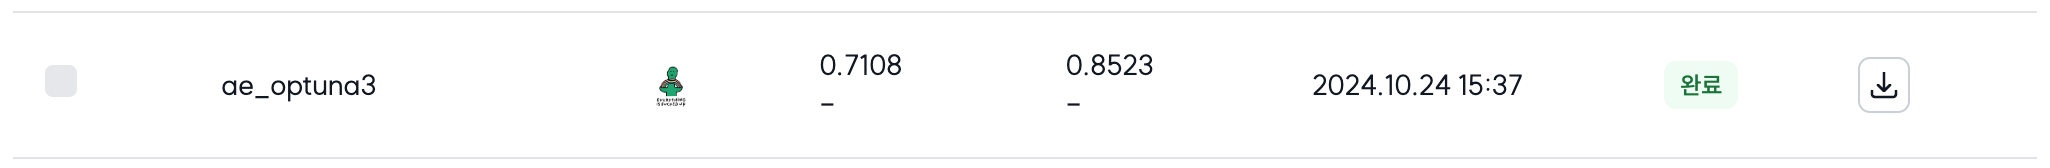